# CNTK 206: パート B - MNIST データを用いた深層畳み込み GAN

**前提条件**: CNTK_103A_MNIST_DataLoader.ipynb というタイトルのチュートリアルを完了して、MNIST データを正常にダウンロードしたことを前提としています。

## 序論

深層学習コミュニティでは、これまで伝統的に(半教師) と教師なし学習用の[識別モデル](https://en.wikipedia.org/wiki/Discriminative_model)を活用してきましたが、[生成モデル](https://en.wikipedia.org/wiki/Generative_model)が[多くの注目](https://openai.com/blog/generative-models/)を集めるようになってきました。

## 概要

前回のチュートリアルでは、NIPS 2014での[Goodfellowら](https://arxiv.org/pdf/1406.2661v1.pdf)による元々の GAN 実装を紹介しました。この先駆的な仕事はその後、発展し多くの技術が公開されました。中でも深層畳み込み敵対的生成ネットワーク、別名 DCGAN がコミュニティでロケット発射装置として推奨されるようになりました。

GAN トレーニングの安定性を改善するための十分テストされたアーキテクチャの制約を持つ DCGAN の実装をこのチュートリアルでは紹介します。

- (弁別器) では[strided 畳み込み](https://en.wikipedia.org/wiki/Convolutional_neural_network)、生成器では[fractional-strided 畳み込み](https://arxiv.org/pdf/1603.07285v1.pdf)を使用します。

- 生成器と弁別器の両方でバッチ正規化を使用しました。

- 深層的なアーキテクチャのため全結合された隠れ層を削除しました。

- 出力のTanhを除いて、生成器のすべての層でReLU活性化関数を使用します。

- 弁別器のすべての層で Leaky ReLU 活性化関数を使用します。

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

%matplotlib inline

実行モードは二つあります:

- *高速モード*: `isFast` は`True`に設定されています。これは、ノートブックのデフォルトのモードで、少ない反復回数で学習または、限られたデータで学習/テストすることを意味します。できたモデルは完全な学習によるものからはほど遠いですが、こうすることによってノートブックの機能の正しさを保証できます。

- *低速モード*: ユーザーがノートブックの内容に慣れ親しんだ後で、学習のためのさまざまなパラメータを変えたり、ノートブックをもっと長期間実行したりして深い洞察を得たくなったときに、このフラグを`False`に設定することをお勧めします。

**注**
`isFlag`が `False` に設定されている場合、ノートブックは GPU ありのマシンでも数時間かかります。`num_minibatches`を、たとえば`20,000` など小さい数値に設定することで、反復回数を減らすことができますが、その場合、生成された画像の品質は犠牲になります。

In [2]:
isFast = True

## データの読み取り

GAN への入力は乱数のベクトルとなります。学習の後にGAN は、 [MNIST データベース](https://en.wikipedia.org/wiki/MNIST_database)から持ってきた手書きの数字の画像を生成することを学びます。ここではチュートリアル103A で作成されたのと同じ MNIST データを使用することになります。 データ形式と読み取り方法の詳細については、前のチュートリアルをご覧ください。 とりあえずは、下の関数は、MNIST データセットからイメージを生成するために使用されるオブジェクトを返すことを気に留めておいてください。ここでは教師なしのモデルを構築しているので、我々は `features` を読みこむだけでよく、 `labels` は無視できます。

In [3]:
# Ensure the training data is generated and available for this tutorial
# We search in two locations in the toolkit for the cached MNIST data set.

data_found = False
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    if os.path.isfile(train_file):
        data_found = True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
    
print("Data directory is {0}".format(data_dir))

Data directory is ../Examples/Image/DataSets/MNIST


In [4]:
def create_reader(path, is_training, input_dim, label_dim):
    deserializer = C.io.CTFDeserializer(
        filename = path,
        streams = C.io.StreamDefs(
            labels_unused = C.io.StreamDef(field = 'labels', shape = label_dim, is_sparse = False),
            features = C.io.StreamDef(field = 'features', shape = input_dim, is_sparse = False
            )
        )
    )
    return C.io.MinibatchSource(
        deserializers = deserializer,
        randomize = is_training,
        max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1
    )

GANを学習させるために使用するランダムノイズは、 `noise_sample` 関数によって得られ、区間 [-1, 1] 内の一様分布からランダムノイズサンプルを生成します。

In [5]:
np.random.seed(123)
def noise_sample(num_samples):
    return np.random.uniform(
        low = -1.0,
        high = 1.0,
        size = [num_samples, g_input_dim]
    ).astype(np.float32)

## モデルの作成

まず、GAN の基礎を簡単に復習します。CNTK 206A に精通しているなら、この節をスキップできます。

GAN ネットワークは、2つのサブネットワークで構成され、1つは生成器($ G $) 、もうひとつは弁別器 ($ D $) と呼ばれます。

- **生成器**は、入力としてランダムノイズベクトル ($ z $) を受け取り、MNISTデータセットからの本物の画像($ x $)と区別できないような(偽の)合成画像($ x^* $)を出力するように仕向けられます。
- **弁別器**は本物の画像（$x$）と偽物の画像（$x^*$）を区別するように仕向けられます。

![](https://www.cntk.ai/jup/GAN_basic_flow.png)

学習の反復ごとに、生成器はより本物らしい偽の画像を生成し (言い換えれば、本物と生成されたものとの違いを*最小限に抑える*) また、弁別器は (トレーニングセットからの)本物の例と生成された偽の例の両方に正しいラベル（本物か偽物）を割り当てられる確率を*最大*にしようとします。サブネットワーク ($ G $と$ D $) の間の2つの相反する目的により、GAN ネットワークは (学習後には)生成器は、本物らしい偽の MNIST 画像を生成し、弁別器はせいぜいランダムに画像が本物か偽物かを推測する均衡状態に落ち着きます。その結果、生成器モデルはランダムは値から本物らしい MNIST 画像を生成できるようになります。

### モデル構成

まずは、モデルのアーキテクチャと学習ハイパーパラメータのいくつかを設定します。

- 生成器ネットワークは、fractional strided 畳み込みネットワークです。 入力は100次元のランダムベクトルとなり、出力は 28 x 28 の偽画像を平坦化したものに相当する784次元ベクトルになります。 弁別器は、strided-畳み込みネットワークです。 これは、入力として784次元の生成器の出力か実際の MNIST 画像を受け取り、単一のスカラー値、つまり入力画像が実際の MNIST 画像である推定確率、を出力します。

### モデルコンポーネント

生成器と弁別器それぞれ１つずつモデルの計算グラフを構築します。まず、モデルのいくつかのアーキテクチャのパラメータを設定します。

In [6]:
# architectural parameters
img_h, img_w = 28, 28
kernel_h, kernel_w = 5, 5 
stride_h, stride_w = 2, 2

# Input / Output parameter of Generator and Discriminator
g_input_dim = 100
g_output_dim = d_input_dim = img_h * img_w

# We expect the kernel shapes to be square in this tutorial and
# the strides to be of the same length along each data dimension
if kernel_h == kernel_w:
    gkernel = dkernel = kernel_h
else:
    raise ValueError('This tutorial needs square shaped kernel') 
            
if stride_h == stride_w:
    gstride = dstride = stride_h
else:
    raise ValueError('This tutorial needs same stride in all dims')

In [7]:
# Helper functions
def bn_with_relu(x, activation=C.relu):
    h = C.layers.BatchNormalization(map_rank=1)(x)
    return C.relu(h)

# We use param-relu function to use a leak=0.2 since CNTK implementation 
# of Leaky ReLU is fixed to 0.01
def bn_with_leaky_relu(x, leak=0.2):
    h = C.layers.BatchNormalization(map_rank=1)(x)
    r = C.param_relu(C.constant((np.ones(h.shape)*leak).astype(np.float32)), h)
    return r

**生成器**

この生成器は、入力 ($z$) として(スターター用に)100次元のランダムベクトルを受け取り、28 x 28 偽 (合成) 画像 ($ x^* $) を平坦化した784次元ベクトルを出力します。このチュートリアルでは、最後のレイヤーを除き、ReLU活性化関数を用いたfractionally strided 畳み込み (つまりConvolutionTranspose)を使用します。生成関数の出力が区間 [-1, 1] におさまっていることを保証するために、最後の層で tanh 活性化関数を使用しています。fractionally strided 畳み込み同様、ReLU と tanh 活性化関数を使うのは重要な鍵です。

In [8]:
def convolutional_generator(z):
    with C.layers.default_options(init=C.normal(scale=0.02)):
        print('Generator input shape: ', z.shape)

        s_h2, s_w2 = img_h//2, img_w//2 #Input shape (14,14)
        s_h4, s_w4 = img_h//4, img_w//4 # Input shape (7,7)
        gfc_dim = 1024
        gf_dim = 64

        h0 = C.layers.Dense(gfc_dim, activation=None)(z)
        h0 = bn_with_relu(h0)
        print('h0 shape', h0.shape)

        h1 = C.layers.Dense([gf_dim * 2, s_h4,  s_w4], activation=None)(h0)
        h1 = bn_with_relu(h1)
        print('h1 shape', h1.shape)

        h2 = C.layers.ConvolutionTranspose2D(gkernel,
                                  num_filters=gf_dim*2,
                                  strides=gstride,
                                  pad=True,
                                  output_shape=(s_h2, s_w2),
                                  activation=None)(h1)
        h2 = bn_with_relu(h2)
        print('h2 shape', h2.shape)

        h3 = C.layers.ConvolutionTranspose2D(gkernel,
                                  num_filters=1,
                                  strides=gstride,
                                  pad=True,
                                  output_shape=(img_h, img_w),
                                  activation=C.sigmoid)(h2)
        print('h3 shape :', h3.shape)

        return C.reshape(h3, img_h * img_w)

**弁別器**

この弁別器は、入力 ($ x^* $) として、生成器のまたは実際の MNIST 画像の784次元出力を受け取り、28 x 28 のイメージに入力を再変換し、入力画像が実際の MNIST 画像である推定確率を出力します。ネットワークは、最後の層を除いてLeaky ReLU活性化関数を用いたstrided 畳み込みを使用してモデル化されます。最後の層でシグモイド活性化関数を使用し、弁別器の出力が[0,1]の区間に収まることを保証します。

In [9]:
def convolutional_discriminator(x):
    with C.layers.default_options(init=C.normal(scale=0.02)):

        dfc_dim = 1024
        df_dim = 64

        print('Discriminator convolution input shape', x.shape)
        x = C.reshape(x, (1, img_h, img_w))

        h0 = C.layers.Convolution2D(dkernel, 1, strides=dstride)(x)
        h0 = bn_with_leaky_relu(h0, leak=0.2)
        print('h0 shape :', h0.shape)

        h1 = C.layers.Convolution2D(dkernel, df_dim, strides=dstride)(h0)
        h1 = bn_with_leaky_relu(h1, leak=0.2)
        print('h1 shape :', h1.shape)

        h2 = C.layers.Dense(dfc_dim, activation=None)(h1)
        h2 = bn_with_leaky_relu(h2, leak=0.2)
        print('h2 shape :', h2.shape)

        h3 = C.layers.Dense(1, activation=C.sigmoid)(h2)
        print('h3 shape :', h3.shape)

        return h3

学習にはミニバッチのサイズとして128、固定した学習率として0.0002を使用しています。高速モード ( `isFast = True` ) では、5000の反復で機能の正しさのみを検証します。

**注**: 低速モードでは、結果の見栄えはよくなりますが、ハードウェアによっては数時間かかります。一般的に、ミニバッチで学習すればするほど、生成される画像の再現性が向上します。

In [10]:
# training config
minibatch_size = 128
num_minibatches = 5000 if isFast else 10000
lr = 0.0002
momentum = 0.5 #equivalent to beta1

### グラフを作成する

計算グラフの残りの部分は主に、いくつかの理由のためGAN特有のトリッキーな学習アルゴリズムとパラメータの更新を扱うためのものです。GANは学習方法やパラメーターにセンシティブです。ここで選択されたパラメーターはコミュニティーが苦労して見出したものです。もし、基本的なGANチュートリアルをすでに読んだのであれば直接コードに進んでもよいでしょう。

- まず、弁別器は、実際の MNIST 画像と生成関数によって生成された偽の画像の両方で使用される必要があります。 計算グラフでこれを表現する1つの方法は、入力を置き換えたうえで弁別関数の出力のクローンを作成することです。 `clone`関数の `method=share` を設定すると、弁別器モデルを通る両方のパスが同じパラメータのセットを使用するようになります。

- 次に、異なる損失関数の勾配を利用して、生成器と弁別器のモデルのパラメータをそれぞれ個別に更新する必要があります。 グラフ内の `Function` のパラメータは`parameters`属性から取得できます。 ただし、モデルパラメータを更新する場合は、他のパラメータを変更せずに、それぞれのモデルのパラメータのみを更新します。つまり、生成器を更新するときには、 $D$ 関数のパラメータを固定したまま、 $G$ 関数のパラメータのみを更新します。

### モデルのトレーニング

GAN を学習させるためのコードは、[もともとのNIPS 2014論文](https://arxiv.org/pdf/1406.2661v1.pdf)のアルゴリズムに忠実に従っています。この実装では、学習データの例と$ G $からのサンプルの両方に正しいラベル (偽か本物) を割り当てる確率を最大化されるように$ D $を訓練します。つまり、 $ D $と$ G $は、次のように２プレーヤーのミニマックスゲームを評価関数$ V(G,D) $で競います。

$$
    \min_G \max_D V(D,G)= \mathbb{E}_{x}[ log D(x) ] + \mathbb{E}_{z}[ log(1 - D(G(z))) ]
$$

このゲームの最適地点では、生成器は本物らしいデータを生成し、分別器は生成された画像が実際に偽物であることを0.5 の確率で予測します。このチュートリアルでは、[以下で参照されるアルゴリズム](https://arxiv.org/pdf/1406.2661v1.pdf)を実装しています。

![](https://www.cntk.ai/jup/GAN_goodfellow_NIPS2014.png)

In [11]:
def build_graph(noise_shape, image_shape, generator, discriminator):
    input_dynamic_axes = [C.Axis.default_batch_axis()]
    Z = C.input_variable(noise_shape, dynamic_axes=input_dynamic_axes)
    X_real = C.input_variable(image_shape, dynamic_axes=input_dynamic_axes)
    X_real_scaled = X_real / 255.0

    # Create the model function for the generator and discriminator models
    X_fake = generator(Z)
    D_real = discriminator(X_real_scaled)
    D_fake = D_real.clone(
        method = 'share',
        substitutions = {X_real_scaled.output: X_fake.output}
    )

    # Create loss functions and configure optimazation algorithms
    G_loss = 1.0 - C.log(D_fake)
    D_loss = -(C.log(D_real) + C.log(1.0 - D_fake))

    G_learner = C.adam(
        parameters = X_fake.parameters,
        lr = C.learning_parameter_schedule_per_sample(lr),
        momentum = C.momentum_schedule(momentum)
    )
    D_learner = C.adam(
        parameters = D_real.parameters,
        lr = C.learning_parameter_schedule_per_sample(lr),
        momentum = C.momentum_schedule(momentum)
    )

    # Instantiate the trainers
    G_trainer = C.Trainer(X_fake,
                        (G_loss, None),
                        G_learner)
    D_trainer = C.Trainer(D_real,
                        (D_loss, None),
                        D_learner)

    return X_real, X_fake, Z, G_trainer, D_trainer

評価関数が定義できたので、GAN モデルを繰り返し訓練することにします。`isFast`フラグがオフになっている場合は特に、ハードウェアによっては、モデルの学習に長い時間がかかることがあります。

In [ ]:
def train(reader_train, generator, discriminator):
    X_real, X_fake, Z, G_trainer, D_trainer = \
        build_graph(g_input_dim, d_input_dim, generator, discriminator)

    # print out loss for each model for upto 25 times
    print_frequency_mbsize = num_minibatches // 25
   
    print("First row is Generator loss, second row is Discriminator loss")
    pp_G = C.logging.ProgressPrinter(print_frequency_mbsize)
    pp_D = C.logging.ProgressPrinter(print_frequency_mbsize)

    k = 2

    input_map = {X_real: reader_train.streams.features}
    for train_step in range(num_minibatches):

        # train the discriminator model for k steps
        for gen_train_step in range(k):
            Z_data = noise_sample(minibatch_size)
            X_data = reader_train.next_minibatch(minibatch_size, input_map)
            if X_data[X_real].num_samples == Z_data.shape[0]:
                batch_inputs = {X_real: X_data[X_real].data, Z: Z_data}
                D_trainer.train_minibatch(batch_inputs)

        # train the generator model for a single step
        Z_data = noise_sample(minibatch_size)
        batch_inputs = {Z: Z_data}

        G_trainer.train_minibatch(batch_inputs)
        G_trainer.train_minibatch(batch_inputs)

        pp_G.update_with_trainer(G_trainer)
        pp_D.update_with_trainer(D_trainer)

        G_trainer_loss = G_trainer.previous_minibatch_loss_average

    return Z, X_fake, G_trainer_loss

In [ ]:
reader_train = create_reader(train_file, True, d_input_dim, label_dim=10)

# G_input, G_output, G_trainer_loss = train(reader_train, dense_generator, dense_discriminator)
G_input, G_output, G_trainer_loss = train(reader_train,
                                          convolutional_generator,
                                          convolutional_discriminator)

Generator input shape:  (100,)
h0 shape (1024,)
h1 shape (128, 7, 7)
h2 shape (128, 14, 14)
h3 shape : (1, 28, 28)
Discriminator convolution input shape (784,)
h0 shape : (1, 12, 12)
h1 shape : (64, 4, 4)
h2 shape : (1024,)
h3 shape : (1,)
First row is Generator loss, second row is Discriminator loss
 Minibatch[   1- 200]: loss = 1.721307 * 25600;
 Minibatch[   1- 200]: loss = 1.162024 * 25600;
 Minibatch[ 201- 400]: loss = 1.746531 * 25600;
 Minibatch[ 201- 400]: loss = 1.173234 * 25600;


In [ ]:
# Print the generator loss 
print("Training loss of the generator is: {0:.2f}".format(G_trainer_loss))

## 偽 (合成) 画像を生成する

モデルを訓練したので、単に生成器にランダムノイズを与えて出力を表示することによって偽の画像を生成することができるようになりました。 以下は、ランダムなサンプルから生成されたいくつかの画像です。 新しいサンプルを取得するには、最後のセルを再実行してください。

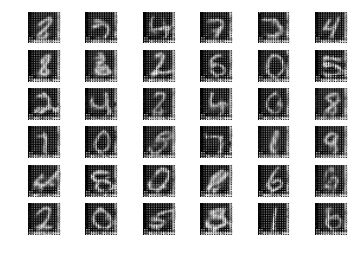

In [16]:
def plot_images(images, subplot_shape):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(*subplot_shape)
    for image, ax in zip(images, axes.flatten()):
        ax.imshow(image.reshape(28, 28), vmin=0, vmax=1.0, cmap='gray')
        ax.axis('off')
    plt.show()


noise = noise_sample(36)
images = G_output.eval({G_input: noise})
plot_images(images, subplot_shape=[6, 6])

反復回数が多いほど、より本物らしい MNIST 画像が生成されます。そうして生成された画像のサンプルを以下に示します。

![](http://www.cntk.ai/jup/cntk206B_dcgan_result.jpg)

**注**: 現実世界の信号の表現をつかむには、多数の反復が必要です。単純な密ネットワークでも非常に効果的なモデリングが可能でした。ただし、MNIST は比較的単純なデータセットでありますが。

**推奨されるタスク**

- Facebook ResearchのSoumith Chintalaによる[記事](https://github.com/soumith/ganhacks)で紹介されているハッキングを参照してください。ハッキングの一部はこのノートブックに組み込まれていますが、他のいくつかは自分で試してみることをお勧めします。

- パフォーマンスは、深層学習の重要な側面です。ミニバッチのサイズの変更が、生成された画像の品質とモデルの学習にかかる時間の両方の点でパフォーマンスに与える影響について調査しましょう。

- トレーニングデータとして CIFAR-10 データセットを使用して偽の画像を生成してみてください。上記のネットワークだとどの程度うまくいきますか？ネットワークが入力ラベルで条件追加されている[条件付き GAN](https://arxiv.org/pdf/1411.1784.pdf)など、GAN にはその他のバリエーションがあります。ラベルを実装してみてください。